# Task 2

Jerry Wang

## Question 1.1

In [179]:
# Import packages
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [180]:
def combine_phol_table(input_path: str) -> pd.DataFrame:
    """
    Given an input path containing all yearly phol data in .csv format, combine them into a single pandas DataFrame.
    :param input_path: str. Path to the folder containing all yearly phol .csv files.
    :return: pd.DataFrame. Output the combined phol table in pandas DataFrame.
    """
    for root, _, files in os.walk(input_path, topdown=False):
        csv_list = [os.path.join(root, name) for name in files]          
    
    combined_df = pd.concat(map(pd.read_csv, csv_list))

    return combined_df

In [181]:
# Read in the csv and combined them
phol_df = combine_phol_table('./Data/Input/public_holidays')

phol_df.to_csv('./Data/Output/combined_phol.csv', index=False)

# Question 1.2

Before we could create the pivot table, we need to convert the `Date` column to proper format first

In [182]:
phol_df['Date'] = pd.to_datetime(phol_df['Date'].astype(str), format='%Y%m%d')

phol_df['Date']

0     2014-01-01
1     2014-01-27
2     2014-03-03
3     2014-03-10
4     2014-03-10
         ...    
103   2022-06-06
104   2022-09-26
105   2022-12-25
106   2022-12-26
107   2022-12-27
Name: Date, Length: 570, dtype: datetime64[ns]

Checking to see if any PHOL has no state information

In [183]:
phol_df[['Applicable To', 'Jurisdiction']].isnull().all(axis=1).sum()

0

We can see that every PHOL has related state information

After observing the CSV file, we see that for each holiday, there's either `Applicable To` or `Jurisdiction` data, so we can combine both into a single column. We then convert `nat` to list of state names in preparing for next steps.

In [184]:
phol_df['State'] = np.where(phol_df['Applicable To'].isna(), phol_df['Jurisdiction'], phol_df['Applicable To'])

phol_df['State'] = phol_df['State'].str.upper()

phol_df['State'] = phol_df['State'].replace('NAT', 'ACT|NSW|VIC|QLD|WA|NT|SA|TAS')

Here we flag whether the state name is contained in the record.

In [185]:
state_list = ['ACT', 'NSW', 'VIC', 'QLD', 'WA', 'NT', 'SA', 'TAS']

for state in state_list:
    phol_df[state] = phol_df['State'].str.contains(state).astype(int)

Creating the weekday column

In [186]:
phol_df['weekday'] = phol_df['Date'].dt.day_name()

Saving a copy and selecting relevant columns

In [187]:
phol_df_copy = phol_df.copy()

phol_df_copy = phol_df_copy[state_list + ['weekday']]

phol_df_copy

,ACT,NSW,VIC,QLD,WA,NT,SA,TAS,weekday
0,1,1,1,1,1,1,1,1,Wednesday
1,1,1,1,1,1,1,1,1,Monday
2,0,0,0,0,1,0,0,0,Monday
3,0,0,0,0,0,0,1,0,Monday
4,1,0,0,0,0,0,0,0,Monday
...,...,...,...,...,...,...,...,...,...
103,0,0,0,0,1,0,0,0,Monday
104,0,0,0,0,1,0,0,0,Monday
105,0,0,0,0,1,0,0,0,Sunday
106,0,0,0,0,1,0,0,0,Monday


Here we transpose the table in preparation for the pivot table

In [188]:
phol_df_copy = phol_df_copy.melt(id_vars='weekday', var_name='State', value_name='Days')

phol_df_copy

,weekday,State,Days
0,Wednesday,ACT,1
1,Monday,ACT,1
2,Monday,ACT,0
3,Monday,ACT,0
4,Monday,ACT,1
...,...,...,...
4555,Monday,TAS,0
4556,Monday,TAS,0
4557,Sunday,TAS,0
4558,Monday,TAS,0


Creating the pivot table

In [189]:
phol_pivot = pd.pivot_table(phol_df_copy, values='Days', index='State', columns='weekday', aggfunc=np.sum)

phol_pivot

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
State,,,,,,,
ACT,16,62,14,12,5,9,6
NSW,16,48,14,14,5,9,6
NT,18,54,14,6,7,11,6
QLD,17,43,15,10,6,9,6
SA,19,54,16,7,9,11,8
TAS,16,47,4,6,5,15,6
VIC,23,42,14,14,5,18,6
WA,16,54,6,5,5,10,6


Creating the stacked bar chart

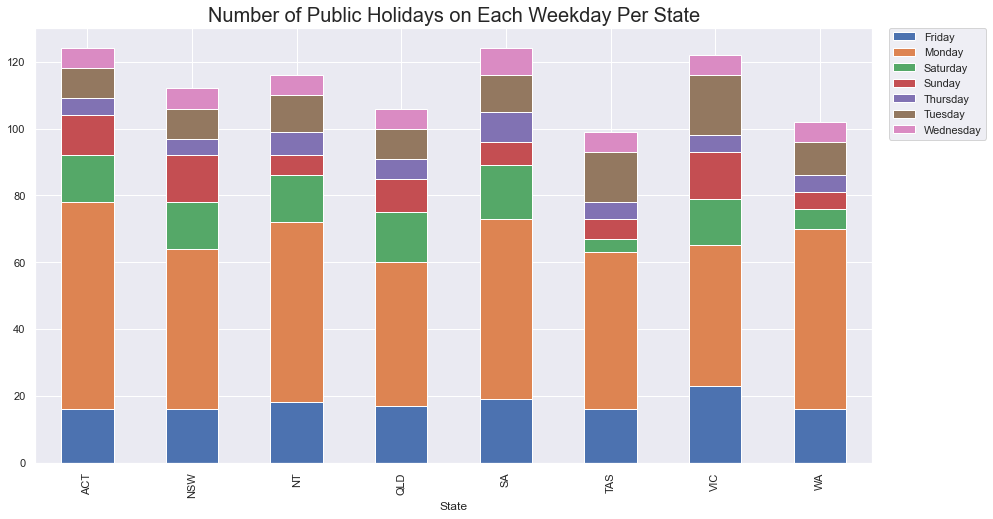

In [190]:
stacked_bar = phol_pivot.plot.bar(stacked=True)

stacked_bar.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

stacked_bar.set_title('Number of Public Holidays on Each Weekday Per State', fontsize=20)

plt.show()

# Question 2.1

In [191]:
emp_master = pd.read_csv('./Data/Input/wage_trust/emp_master.csv')

emp_master_subset = emp_master[['emp_id', 'award', 'classification', 'worker_type',
                                'shift_type', 'work_pattern', 'salary']].copy()

emp_master_subset

,emp_id,award,classification,worker_type,shift_type,work_pattern,salary
0,0,BFI,Level 1,FULL_TIME,DAY_WORKER,TA221,67429.69622
1,1,BFI,Level 1,FULL_TIME,DAY_WORKER,TA221,70187.80411
2,2,BFI,Level 1,FULL_TIME,DAY_WORKER,TA221,63334.51831
3,3,BFI,Level 1,FULL_TIME,DAY_WORKER,TA221,67633.42588
4,193,BFI,Level 1,FULL_TIME,DAY_WORKER,TA216,58593.09727
...,...,...,...,...,...,...,...
4622,3845,CPSA,Level 1 - Year 1,FULL_TIME,DAY_WORKER,TA22,46362.90605
4623,3947,CPSA,Level 1 - Year 1,FULL_TIME,DAY_WORKER,TA42,68315.21893
4624,4370,CPSA,Level 1 - Year 1,FULL_TIME,DAY_WORKER,TA13,63835.38215
4625,4786,CPSA,Level 1 - Year 1,FULL_TIME,DAY_WORKER,TA5,53572.45211


In [192]:
for col in emp_master_subset:
    if col not in ['emp_id', 'salary']:
        print(emp_master_subset[col].value_counts(), '\n')

BFI     3305
CPSA    1322
Name: award, dtype: int64 

Level 6                                              1069
Level 5                                               937
Level 4                                               901
Level 3                                               796
Level 2                                               329
Level 1                                               161
Call centre technical associate                       111
Level 2 - Year 2                                       99
Level 1 - Year 3                                       70
Call centre principal customer contact specialist      70
Level 2 - Year 1                                       42
Level 1 - Year 2                                       28
Level 1 - Year 1                                       14
Name: classification, dtype: int64 

FULL_TIME    4627
Name: worker_type, dtype: int64 

DAY_WORKER      4258
SHIFT_WORKER     369
Name: shift_type, dtype: int64 

TA28     136
TA46     126
TA

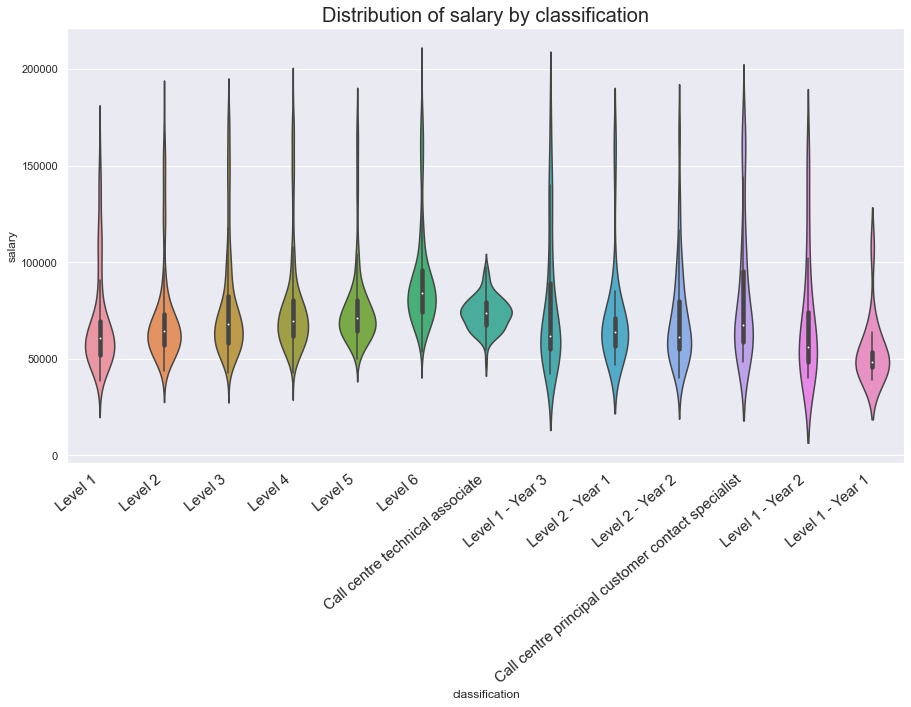

In [193]:
sns.set(rc = {'figure.figsize':(15,8)})

violin_plot = sns.violinplot(x='classification', y='salary', data=emp_master_subset)
violin_plot.set_title('Distribution of salary by classification', fontsize=20)
violin_plot.set_xticklabels(violin_plot.get_xticklabels(), rotation=40, ha='right', fontsize=15)

plt.show()

# Question 2.2

In [194]:
filtered_emp_master = emp_master.loc[(emp_master['award'] == 'BFI') &
                                     (emp_master['worker_type'] == 'FULL_TIME') &
                                     (emp_master['shift_type'] == 'DAY_WORKER') &
                                     (emp_master['phol_location'] == 'NSW') &
                                     (emp_master['work_pattern'] == 'TA1'),
                                     :
                                     ].copy()

filtered_emp_master

,emp_id,award,phol_location,classification,worker_type,shift_type,work_pattern,salary,entitled_pay,5% buffer,10% buffer,15% buffer,20% buffer,25% buffer,30% buffer
67,1897,BFI,NSW,Level 1,FULL_TIME,DAY_WORKER,TA1,49733.85001,42885.43366,45029.70535,47173.97703,49318.24871,51462.52040,53606.79208,55751.06376
68,1898,BFI,NSW,Level 1,FULL_TIME,DAY_WORKER,TA1,58405.98777,42885.43366,45029.70535,47173.97703,49318.24871,51462.52040,53606.79208,55751.06376
69,1899,BFI,NSW,Level 1,FULL_TIME,DAY_WORKER,TA1,51115.41768,42885.43366,45029.70535,47173.97703,49318.24871,51462.52040,53606.79208,55751.06376
70,1900,BFI,NSW,Level 1,FULL_TIME,DAY_WORKER,TA1,50709.30796,42885.43366,45029.70535,47173.97703,49318.24871,51462.52040,53606.79208,55751.06376
275,1901,BFI,NSW,Level 2,FULL_TIME,DAY_WORKER,TA1,59716.33681,46951.81215,49299.40276,51646.99337,53994.58397,56342.17458,58689.76519,61037.35580
276,1902,BFI,NSW,Level 2,FULL_TIME,DAY_WORKER,TA1,54864.21319,46951.81215,49299.40276,51646.99337,53994.58397,56342.17458,58689.76519,61037.35580
277,1903,BFI,NSW,Level 2,FULL_TIME,DAY_WORKER,TA1,56022.68096,46951.81215,49299.40276,51646.99337,53994.58397,56342.17458,58689.76519,61037.35580
278,1904,BFI,NSW,Level 2,FULL_TIME,DAY_WORKER,TA1,56831.36378,46951.81215,49299.40276,51646.99337,53994.58397,56342.17458,58689.76519,61037.35580
279,1905,BFI,NSW,Level 2,FULL_TIME,DAY_WORKER,TA1,58970.84024,46951.81215,49299.40276,51646.99337,53994.58397,56342.17458,58689.76519,61037.35580
280,1906,BFI,NSW,Level 2,FULL_TIME,DAY_WORKER,TA1,60837.79085,46951.81215,49299.40276,51646.99337,53994.58397,56342.17458,58689.76519,61037.35580


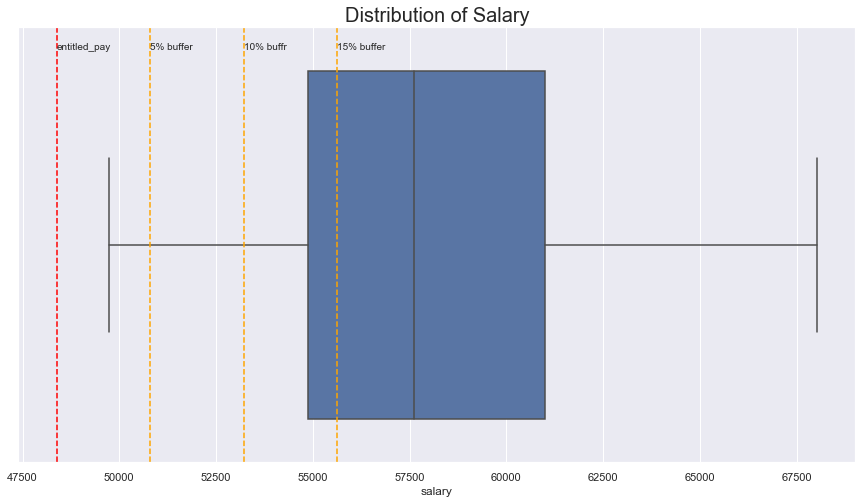

In [195]:
fig, ax = plt.subplots()

boxplot = sns.boxplot(x='salary', data=filtered_emp_master)
boxplot.axvline(filtered_emp_master['entitled_pay'].mean(), linestyle='--', color='red')
boxplot.axvline(filtered_emp_master['5% buffer'].mean(), linestyle='--', color='orange')
boxplot.axvline(filtered_emp_master['10% buffer'].mean(), linestyle='--', color='orange')
boxplot.axvline(filtered_emp_master['15% buffer'].mean(), linestyle='--', color='orange')
boxplot.set_title('Distribution of Salary', fontsize=20)
boxplot.text(filtered_emp_master['entitled_pay'].mean(), -0.45, 'entitled_pay', fontsize=10)
boxplot.text(filtered_emp_master['5% buffer'].mean(), -0.45, '5% buffer', fontsize=10)
boxplot.text(filtered_emp_master['10% buffer'].mean(), -0.45, '10% buffr', fontsize=10)
boxplot.text(filtered_emp_master['15% buffer'].mean(), -0.45, '15% buffer', fontsize=10)

plt.show()

# Question 3


In [196]:
penalty_ot = pd.read_csv('./Data/Input/wage_trust/penalty_ot_breakdown.csv')

combined_emp = penalty_ot.merge(emp_master, left_on='emp_id', right_on='emp_id').copy()

combined_emp_subset = combined_emp[['date', 'time_type', 'duration', 'award']].copy()

combined_emp_subset

,date,time_type,duration,award
0,2021-07-01,PERMANENT_AFTERNOON,8.333333,BFI
1,2021-07-02,PERMANENT_AFTERNOON,8.333333,BFI
2,2021-07-05,PERMANENT_AFTERNOON,8.333333,BFI
3,2021-07-06,PERMANENT_AFTERNOON,8.333333,BFI
4,2021-07-07,PERMANENT_AFTERNOON,8.333333,BFI
...,...,...,...,...
1301033,2022-06-24,AFTERNOON,8.000000,CPSA
1301034,2022-06-27,AFTERNOON,8.000000,CPSA
1301035,2022-06-28,AFTERNOON,8.000000,CPSA
1301036,2022-06-29,AFTERNOON,8.000000,CPSA


In [210]:
def penalty_ot_heatmap(breakdown_df: pd.DataFrame) -> plt.subplots:
    """
    Given an input data frame of employee TS, create heatmaps based on date and time type.
    :param breakdown_df: pd.DataFrame. Employee TS dataframe.
    """
    for award in ('BFI', 'CPSA'):
        df = breakdown_df[breakdown_df['award'] == award].copy()
        df.drop(columns=['award'], inplace=True)
        df_pivot = pd.pivot_table(df, values='duration', index='time_type', columns='date', aggfunc=np.mean)
        df_pivot = df_pivot.fillna(0)
        heatmap = sns.heatmap(df_pivot, cmap='Blues')
        heatmap.set_title(f'Heatmap of hours worked by date and time type for {award} employees.', fontsize=20)
        plt.show()

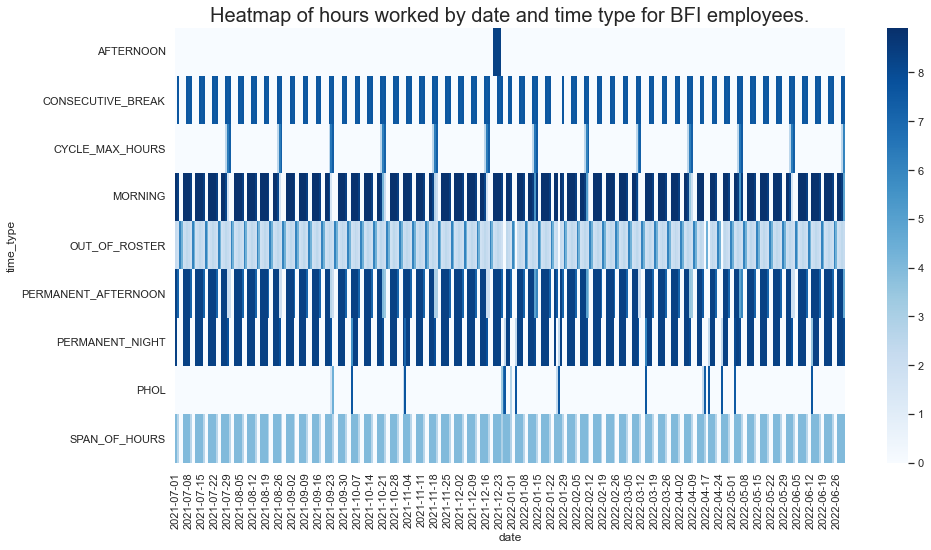

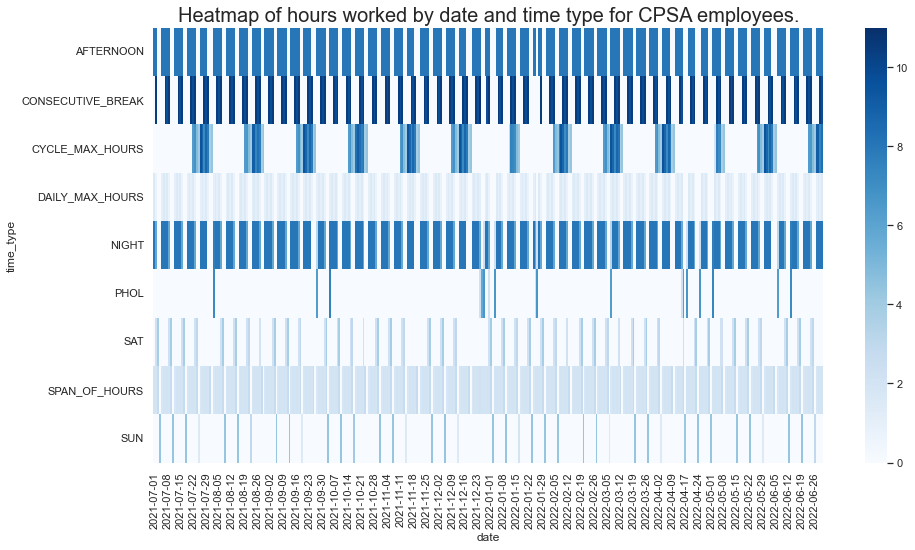

In [211]:
penalty_ot_heatmap(combined_emp_subset)